## Importing All Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import time
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components, plot
from prophet.diagnostics import performance_metrics
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')
%matplotlib inline

## Importing Dataset i.e. GOOGLE (GOOGL) Stock Price Dataset

In [2]:
df = yf.download('GOOGL', start='2004-08-19', end=datetime.today())

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,,
2004-08-19 00:00:00+00:00,2.504808,2.511011,2.604104,2.401401,2.502503,893181924
2004-08-20 00:00:00+00:00,2.703765,2.710460,2.729730,2.515015,2.527778,456686856
2004-08-23 00:00:00+00:00,2.730976,2.737738,2.839840,2.728979,2.771522,365122512
2004-08-24 00:00:00+00:00,2.617892,2.624374,2.792793,2.591842,2.783784,304946748
2004-08-25 00:00:00+00:00,2.646101,2.652653,2.702703,2.599600,2.626627,183772044


In [4]:
df.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,,
2024-11-18 00:00:00+00:00,175.300003,175.300003,175.440002,172.899994,173.419998,20206600
2024-11-19 00:00:00+00:00,178.119995,178.119995,178.869995,173.559998,173.720001,23434900
2024-11-20 00:00:00+00:00,175.979996,175.979996,177.679993,173.779999,177.339996,18997100
2024-11-21 00:00:00+00:00,167.630005,167.630005,174.130005,163.699997,173.899994,59734400
2024-11-22 00:00:00+00:00,164.759995,164.759995,166.460007,163.899994,165.850006,38560400


In [5]:
df.duplicated().sum()

0

In [6]:
df.columns = df.columns.get_level_values(0)
df

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2004-08-19 00:00:00+00:00,2.504808,2.511011,2.604104,2.401401,2.502503,893181924
2004-08-20 00:00:00+00:00,2.703765,2.710460,2.729730,2.515015,2.527778,456686856
2004-08-23 00:00:00+00:00,2.730976,2.737738,2.839840,2.728979,2.771522,365122512
2004-08-24 00:00:00+00:00,2.617892,2.624374,2.792793,2.591842,2.783784,304946748
2004-08-25 00:00:00+00:00,2.646101,2.652653,2.702703,2.599600,2.626627,183772044
...,...,...,...,...,...,...
2024-11-18 00:00:00+00:00,175.300003,175.300003,175.440002,172.899994,173.419998,20206600
2024-11-19 00:00:00+00:00,178.119995,178.119995,178.869995,173.559998,173.720001,23434900
2024-11-20 00:00:00+00:00,175.979996,175.979996,177.679993,173.779999,177.339996,18997100


## Copying the dataset for future use

In [7]:
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.tz_localize(None)
df.set_index('Date', inplace=True)

### Dropping unwanted column

In [8]:
df.drop(['Adj Close'], axis=1, inplace=True)

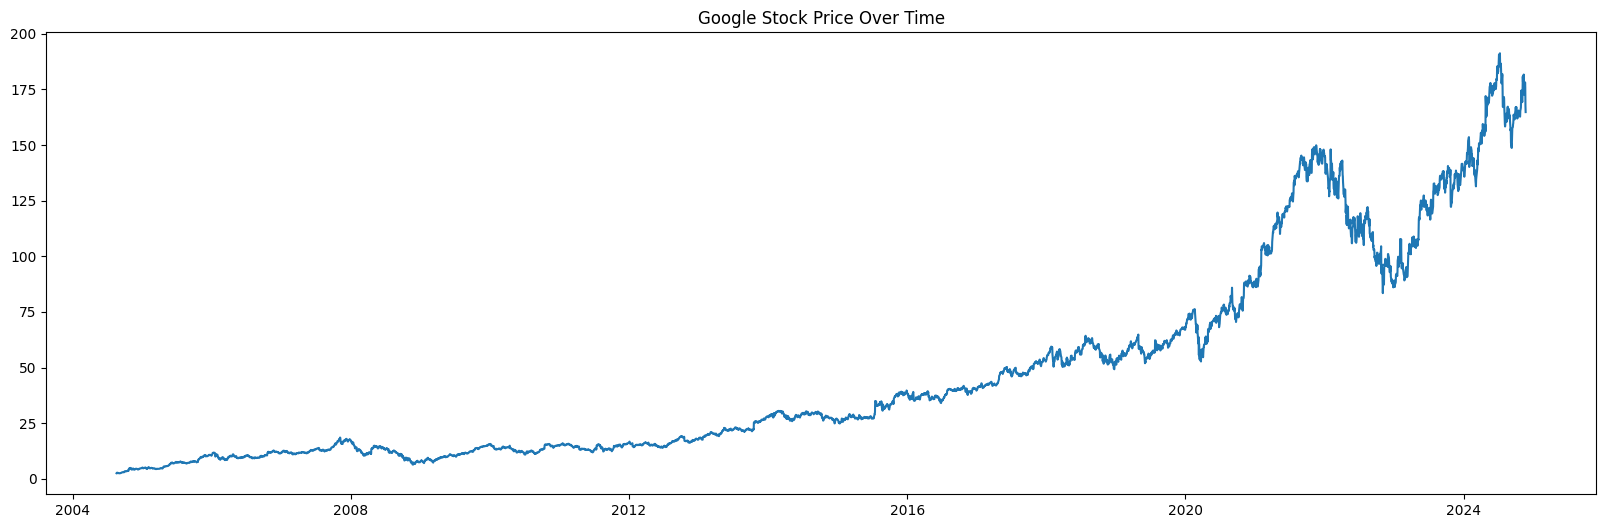

In [9]:
# Visualize the close price
plt.figure(figsize=(20,6))
plt.plot(df['Close'])
plt.title('Google Stock Price Over Time')
plt.show()

In [10]:
df.reset_index(inplace=True)

### Converting date column to datetime format and selecting the oly date and close price columns

In [11]:
df['ds'] = pd.to_datetime(df['Date'])  # Convert date column to datetime format
df['y'] = df['Close']  # Assume 'Close' is the closing price you want to predict
df = df[['ds', 'y']]


### Splitting the data into train set and test set

In [12]:
# train = df.iloc[:len(df) - 30]  # Use all but the last 30 days for training
train = df
test = df.iloc[len(df) - 365:]   # Use the last 30 days for testing

### Model Building and Forcasting the future stock prices

In [13]:
model = Prophet(daily_seasonality=True)
start = time.time()
model.fit(train)
end = time.time()
print('Time taken to train the model:', end - start)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbhkx8x42/81b7lb2q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbhkx8x42/kflj61uq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59945', 'data', 'file=/tmp/tmpbhkx8x42/81b7lb2q.json', 'init=/tmp/tmpbhkx8x42/kflj61uq.json', 'output', 'file=/tmp/tmpbhkx8x42/prophet_modelzwgxgp6n/prophet_model-20241123225635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:56:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:56:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Time taken to train the model: 6.552415132522583


In [14]:
# Generate future dates
future = model.make_future_dataframe(periods=len(test), freq='D')

# Predict
forecast = model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2004-08-19,2.851966,-6.267009,17.817376,2.851966,2.851966,2.549999,2.549999,2.549999,1.39501,...,0.058511,0.058511,0.058511,1.096478,1.096478,1.096478,0.0,0.0,0.0,5.401965
1,2004-08-20,2.860314,-6.950280,16.988686,2.860314,2.860314,2.551096,2.551096,2.551096,1.39501,...,0.068879,0.068879,0.068879,1.087207,1.087207,1.087207,0.0,0.0,0.0,5.411410
2,2004-08-23,2.885360,-6.571158,18.952692,2.885360,2.885360,2.555729,2.555729,2.555729,1.39501,...,0.111555,0.111555,0.111555,1.049164,1.049164,1.049164,0.0,0.0,0.0,5.441089
3,2004-08-24,2.893708,-6.536784,17.840792,2.893708,2.893708,2.487186,2.487186,2.487186,1.39501,...,0.060901,0.060901,0.060901,1.031275,1.031275,1.031275,0.0,0.0,0.0,5.380894
4,2004-08-25,2.902057,-7.226865,17.942691,2.902057,2.902057,2.453870,2.453870,2.453870,1.39501,...,0.048906,0.048906,0.048906,1.009954,1.009954,1.009954,0.0,0.0,0.0,5.355927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5462,2025-11-18,171.213315,161.281507,186.456059,168.916840,173.205464,2.194680,2.194680,2.194680,1.39501,...,0.060901,0.060901,0.060901,0.738769,0.738769,0.738769,0.0,0.0,0.0,173.407995
5463,2025-11-19,171.256087,161.922569,185.833870,168.947564,173.250875,2.148500,2.148500,2.148500,1.39501,...,0.048906,0.048906,0.048906,0.704585,0.704585,0.704585,0.0,0.0,0.0,173.404587
5464,2025-11-20,171.298858,161.181702,186.713148,168.978288,173.296286,2.115260,2.115260,2.115260,1.39501,...,0.058511,0.058511,0.058511,0.661739,0.661739,0.661739,0.0,0.0,0.0,173.414119
5465,2025-11-21,171.341630,161.159544,185.350935,169.009013,173.341698,2.074619,2.074619,2.074619,1.39501,...,0.068879,0.068879,0.068879,0.610730,0.610730,0.610730,0.0,0.0,0.0,173.416248


In [15]:
predicted_values = forecast[['ds', 'yhat']].set_index('ds').loc[test['ds']]
test['yhat'] = predicted_values['yhat'].values
test

Price,ds,y,yhat
4737,2023-06-14,123.669998,135.114612
4738,2023-06-15,125.089996,135.145165
4739,2023-06-16,123.529999,135.178519
4740,2023-06-20,123.099998,135.292081
4741,2023-06-21,120.550003,135.319856
...,...,...,...
5097,2024-11-18,175.300003,157.839360
5098,2024-11-19,178.119995,157.795090
5099,2024-11-20,175.979996,157.780927
5100,2024-11-21,167.630005,157.780349


In [16]:
mse = mean_squared_error(test['y'], test['yhat'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['y'], test['yhat'])
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 197.38139169479183
Root Mean Squared Error: 14.04924879467909
Mean Absolute Error: 11.176736998729904


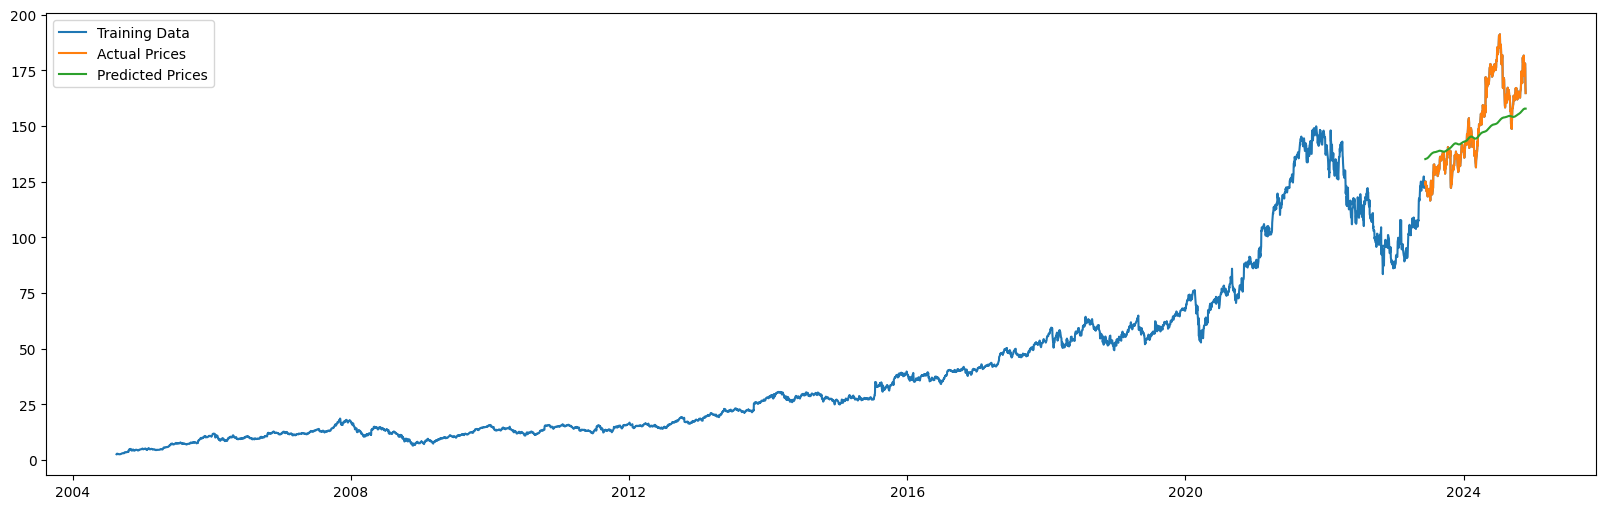

In [17]:
plt.figure(figsize=(20, 6))
plt.plot(train['ds'], train['y'], label='Training Data')
plt.plot(test['ds'], test['y'], label='Actual Prices')
plt.plot(test['ds'], test['yhat'], label='Predicted Prices')
plt.legend()
plt.show()

In [18]:
plot_plotly(model, forecast)

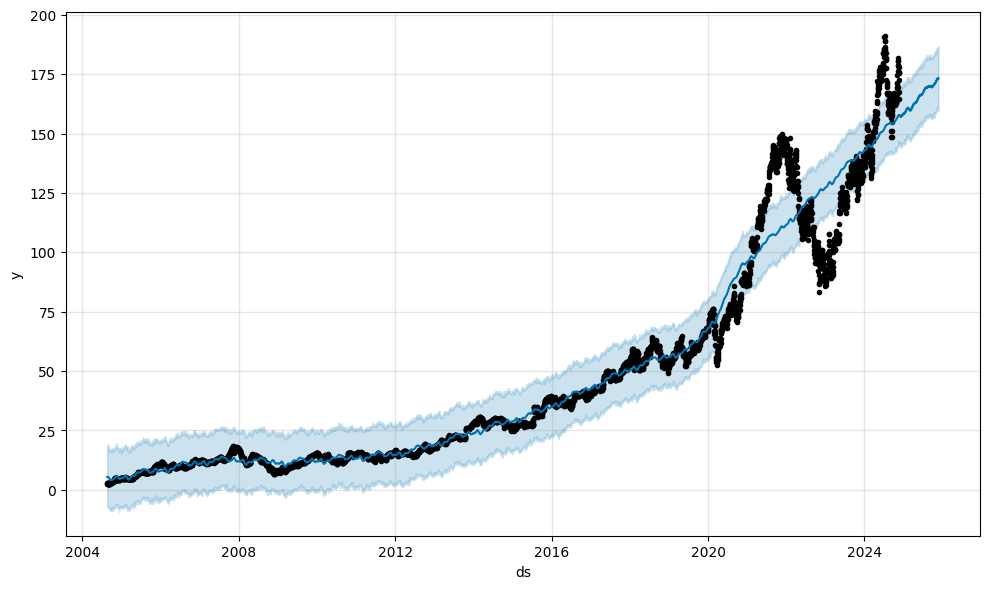

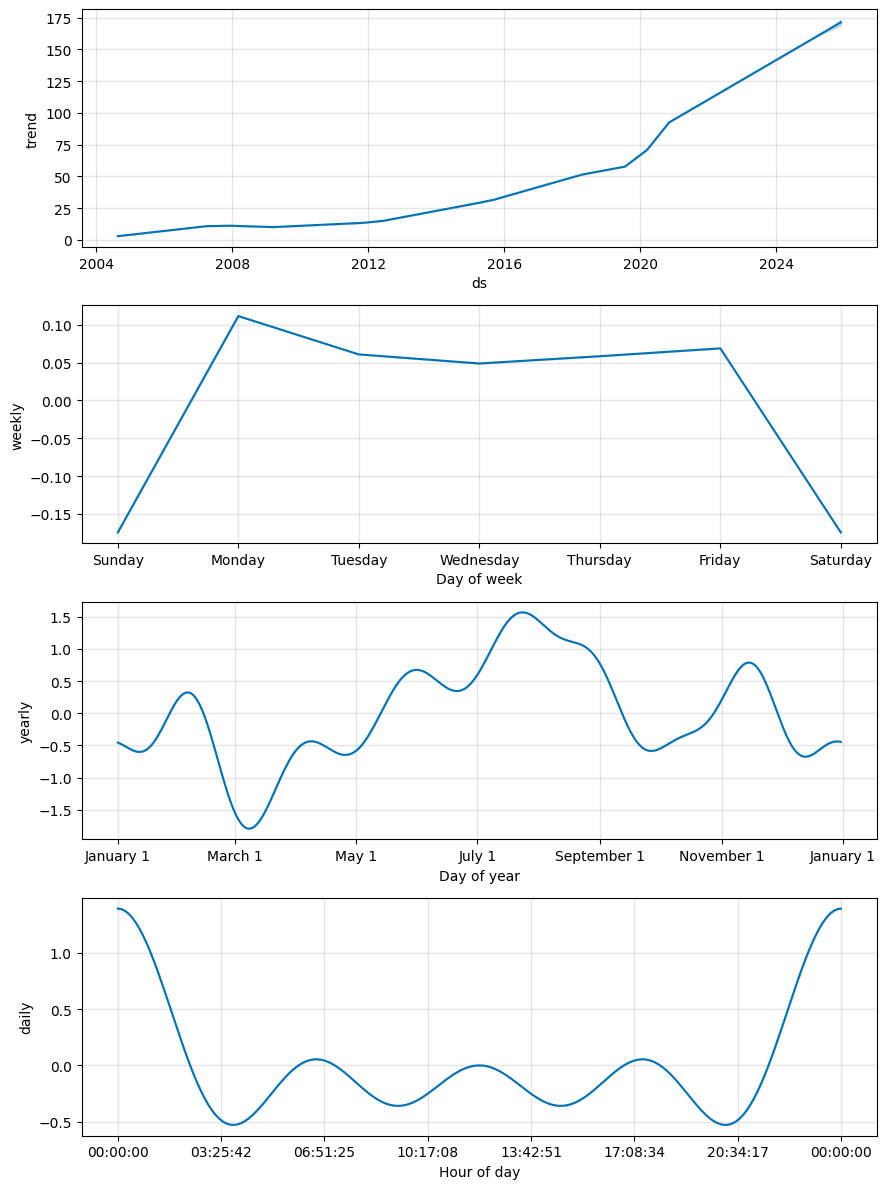

In [19]:
plot(model, forecast)               # Plot the forecast
plot_components(model, forecast)    # Plot the forecast components
plt.show()